In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

False

In [8]:
ticker = 'META'
df = yf.download(ticker, '2020-01-01')

C:\Users\denni\AppData\Local\Temp\ipykernel_16048\1920134332.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [9]:
df

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2020-01-02,208.635406,208.645346,205.144563,205.621940,12077100
2020-01-03,207.531464,209.252020,205.820847,206.079438,11188400
2020-01-06,211.440048,211.619059,205.393219,205.572230,17058900
2020-01-07,211.897507,213.409218,210.594657,211.658826,14912400
2020-01-08,214.045746,215.060185,211.449986,211.837857,13475000
...,...,...,...,...,...
2025-08-29,738.700012,747.140015,735.349976,745.280029,9070500
2025-09-02,735.109985,736.000000,721.729980,726.039978,9350900


<Axes: xlabel='Date'>

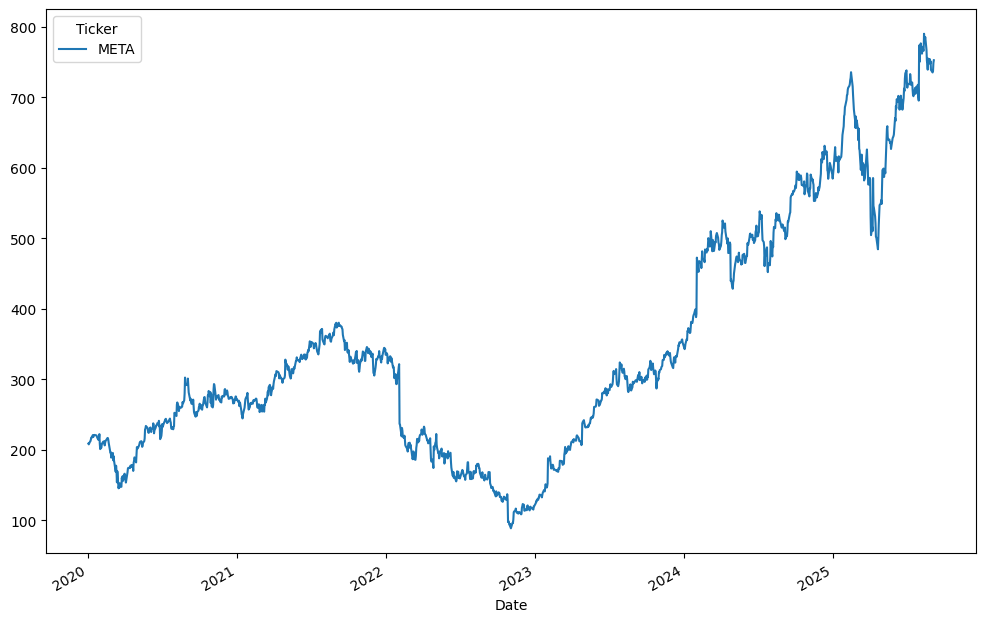

In [11]:
df.Close.plot(figsize = (12, 8))

In [12]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [14]:
df.Close

Ticker,META
Date,
2020-01-02,-0.802366
2020-01-03,-0.808973
2020-01-06,-0.785580
2020-01-07,-0.782842
2020-01-08,-0.769985
...,...
2025-08-29,2.370056
2025-09-02,2.348570
2025-09-03,2.360181


In [ ]:
seq_length = 30 # How many days of data we want to use for prediction
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length]) # We would use 29 days and i+seq_length would be the prediction date

data = np.array(data)

train_size = int(0.8 * len(data)) # Training data

X_train = torch.from_numpy(data[:train_size, :-1, :]) # 29 elements up
y_train = torch.from_numpy(data[:train_size, -1, :]) # 30th Last element
X_test = torch.from_numpy(data[train_size:, -1, :])
y_test = torch.from_numpy(data[train_size:, -1, :])

In [21]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


In [ ]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)